In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.optim import lr_scheduler
import numpy as np 
import torchvision 
from torchvision import datasets , models, transforms 
import matplotlib.pyplot as plt 
import time 
import os 
import copy 
from tqdm.notebook import tqdm

In [2]:
train_transform = transforms.Compose([
                                    transforms.RandomResizedCrop(224), 
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
                                    transforms.Resize(256), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [3]:
# getting the dataset in 
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2021-09-11 12:04:18--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.224.68, 52.85.224.54, 52.85.224.118, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.224.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  67.4MB/s    in 0.7s    

2021-09-11 12:04:19 (67.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# unzipping the dataset 
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [5]:
data_dir = '/content/hymenoptera_data'
image_datasets = {"train" : datasets.ImageFolder(data_dir+'/train',
                                                 train_transform),
                  "val": datasets.ImageFolder(data_dir + "/val",
                                               val_transform)}


dataloaders = {"train": torch.utils.data.DataLoader(
    image_datasets['train'], batch_size = 4, shuffle = True, num_workers = 4
),
"val" : torch.utils.data.DataLoader(
    image_datasets['val'], batch_size = 4, shuffle = True, num_workers =4 
)
}

dataset_sizes = {"train": len(image_datasets['train']),
                 "val":len(image_datasets['val'])}

class_name = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# visualizing some images before working on it further 

def imshow(inp , title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean 
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


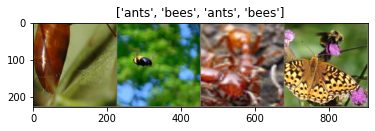

In [7]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_name[x] for x in classes])

In [8]:
# making training loop for model

def train_model(model, criterion , optimizer , scheduler , num_epochs = 25 ):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in tqdm(range(num_epochs)):
    print(f'Epoch {epoch} / {num_epochs-1}')
    print('-' * 10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss = 0.0 
      running_corrects = 0 
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)
      if phase == 'train':
        scheduler.step()
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print(f'{phase} Loss:{epoch_loss} Acc : {epoch_acc}')
      if phase =='val' and epoch_acc > best_acc:
        best_acc = epoch_acc 
        best_model_wts = copy.deepcopy(model.state_dict())
    print()

  time_elapsed = time.time() - since
  print(f'training completed in {time_elapsed // 60} {time_elapsed%60}')
  print(f'best val acc : {best_acc}')
  model.load_state_dict(best_model_wts)
  return model 


In [21]:
# visulizing the model 
def visulaize_model(model , num_images = 6 ) : 
  was_training = model.training 
  model.eval()
  images_so_far = 0 
  fig = plt.figure()
  with torch.no_grad():
    for i , (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _,preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1 
        ax = plt.subplot(num_images//2 , 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted {class_name[preds[j]]}')
        imshow(inputs.cpu().data[j])
        if images_so_far == num_images:
          model.train(mode = was_training)
          return 
      model.train(mode = was_training)

In [10]:
# loading the pretrined model 

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs , 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_ft , step_size = 7 , gamma = 0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
# trianing and evaluating 

model_ft = train_model(model_ft , criterion, optimizer_ft , exp_lr_scheduler, 
                       num_epochs = 25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 / 24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss:0.9480516649782658 Acc : 0.5532786885245902
val Loss:1.8733812418638491 Acc : 0.43137254901960786

Epoch 1 / 24
----------
train Loss:0.7204466550076594 Acc : 0.4713114754098361
val Loss:0.8445538687550165 Acc : 0.5359477124183006

Epoch 2 / 24
----------
train Loss:0.7042853070087121 Acc : 0.5778688524590164
val Loss:0.9321319643968071 Acc : 0.6535947712418301

Epoch 3 / 24
----------
train Loss:0.7680134353090505 Acc : 0.5163934426229508
val Loss:4.7065493728649 Acc : 0.5228758169934641

Epoch 4 / 24
----------
train Loss:0.7102014632498632 Acc : 0.5286885245901639
val Loss:1.9265809970743515 Acc : 0.5098039215686274

Epoch 5 / 24
----------
train Loss:0.6825968437507505 Acc : 0.5819672131147541
val Loss:0.8175612076435214 Acc : 0.6797385620915033

Epoch 6 / 24
----------
train Loss:0.6977364235236997 Acc : 0.5491803278688525
val Loss:1.6895729170905218 Acc : 0.49673202614379086

Epoch 7 / 24
----------
train Loss:0.6578220080156796 Acc : 0.6147540983606558
val Loss:0.6920

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


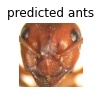

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


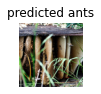

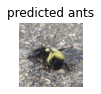

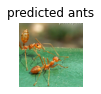

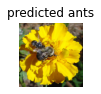

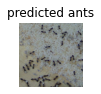

In [22]:
visulaize_model(model_ft)

In [15]:
# working on convnet 

model_conv = torchvision.models.resnet18(pretrained= True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs , 2)
model_conv = model_conv.to(device)

criterion =nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001)

In [17]:
model_conv = train_model(model_conv , criterion , optimizer_conv, exp_lr_scheduler, num_epochs = 25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 / 24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss:0.6723488769570335 Acc : 0.5860655737704918
val Loss:0.5691302309628405 Acc : 0.7320261437908497

Epoch 1 / 24
----------
train Loss:0.595172076928811 Acc : 0.7008196721311476
val Loss:0.4867536489870034 Acc : 0.803921568627451

Epoch 2 / 24
----------
train Loss:0.5294988932179623 Acc : 0.7622950819672132
val Loss:0.40570775005552506 Acc : 0.8431372549019608

Epoch 3 / 24
----------
train Loss:0.4817958767296838 Acc : 0.7663934426229508
val Loss:0.40008994839549844 Acc : 0.869281045751634

Epoch 4 / 24
----------
train Loss:0.48186668509342634 Acc : 0.7745901639344263
val Loss:0.34486176789391276 Acc : 0.8954248366013072

Epoch 5 / 24
----------
train Loss:0.3812572430880343 Acc : 0.8729508196721312
val Loss:0.30699219637446934 Acc : 0.9084967320261438

Epoch 6 / 24
----------
train Loss:0.4526571079355771 Acc : 0.7827868852459017
val Loss:0.2863467060321686 Acc : 0.9150326797385622

Epoch 7 / 24
----------
train Loss:0.38808600115971487 Acc : 0.819672131147541
val Loss:0.2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


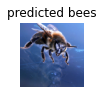

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


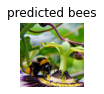

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


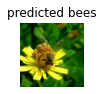

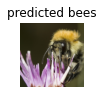

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


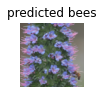

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


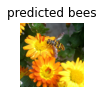

In [23]:
visulaize_model(model_conv)

plt.show()